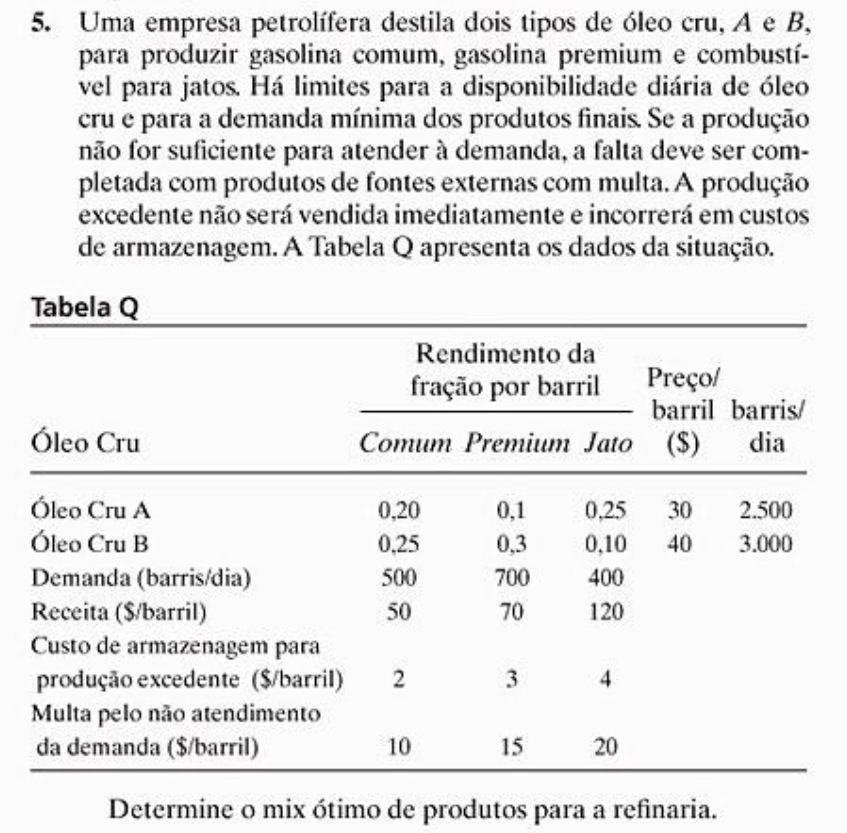

In [1]:
%pip install cplex
%pip install docplex

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
from docplex.mp.model import Model

# Criação do modelo com um nome descritivo
model = Model('Producao_Refinaria_Excedente_Falta')

In [3]:
# --- Parâmetros extraídos do enunciado e da Tabela Q ---

# Identificadores
oleos_crus = ['A', 'B']
produtos = ['comum', 'premium', 'jato']

# Dados do Óleo Cru
disponibilidade_cru = {'A': 2500, 'B': 3000} # barris/dia
custo_cru = {'A': 30, 'B': 40} # $/barril
rendimento = {
    'A': {'comum': 0.20, 'premium': 0.10, 'jato': 0.25},
    'B': {'comum': 0.25, 'premium': 0.30, 'jato': 0.10}
}

# Dados dos Produtos Finais
demanda = {'comum': 500, 'premium': 700, 'jato': 400} # barris/dia
custo_armazenagem = {'comum': 2, 'premium': 3, 'jato': 4} # $/barril excedente
custo_falta = {'comum': 10, 'premium': 15, 'jato': 20} # $/barril em falta
# A receita não é necessária para um modelo de minimização de custo, pois a demanda é fixa.

In [4]:
# 1. Variáveis de Decisão
# Quantidade de cada óleo cru a ser processado
oleo_usado = model.continuous_var_dict(oleos_crus, name='Cru')

# Quantidade de cada produto final que é efetivamente produzida internamente
producao_interna = model.continuous_var_dict(produtos, name='Prod', lb=0)

# Quantidade de cada produto armazenado como excedente
excedente = model.continuous_var_dict(produtos, name='Excedente', lb=0)

# Quantidade de cada produto em falta (a ser comprado externamente)
falta = model.continuous_var_dict(produtos, name='Falta', lb=0)


# 2. Função Objetivo
# Minimizar o Custo Total = Custo do Óleo Cru + Custo de Armazenagem + Custo da Falta
expressao_custo_cru = (custo_cru[o] * oleo_usado[o] for o in oleos_crus)
soma_custo_cru = model.sum(expressao_custo_cru)

expressao_custo_arm = (custo_armazenagem[p] * excedente[p] for p in produtos)
soma_custo_arm = model.sum(expressao_custo_arm)

expressao_custo_falta = (custo_falta[p] * falta[p] for p in produtos)
soma_custo_falta = model.sum(expressao_custo_falta)

custo_total = soma_custo_cru + soma_custo_arm + soma_custo_falta
model.minimize(custo_total)


# 3. Restrições

# Restrição 1: Disponibilidade de Óleo Cru
for o in oleos_crus:
    restr_disponibilidade_logica = oleo_usado[o] <= disponibilidade_cru[o]
    model.add_constraint(restr_disponibilidade_logica, ctname=f'disponibilidade_cru_{o}')

# Restrição 2: Balanço da Produção (Rendimento)
# A produção interna de cada produto é igual ao rendimento da mistura de óleos crus.
for p in produtos:
    expressao_rendimento = (rendimento[o][p] * oleo_usado[o] for o in oleos_crus)
    soma_produzida = model.sum(expressao_rendimento)
    restr_rendimento_logica = producao_interna[p] == soma_produzida
    model.add_constraint(restr_rendimento_logica, ctname=f'balanco_prod_{p}')

# Restrição 3: Balanço da Demanda
# A demanda de cada produto deve ser atendida pela (Produção Interna - Excedente + Falta).
for p in produtos:
    restr_balanco_demanda_logica = producao_interna[p] - excedente[p] + falta[p] == demanda[p]
    model.add_constraint(restr_balanco_demanda_logica, ctname=f'balanco_demanda_{p}')

In [5]:
# Aciona o solver para encontrar a solução
print("--- Resolvendo o modelo ---")
solucao = model.solve(log_output=True)

print('\n------ SOLUÇÃO ÓTIMA ------\n')
if solucao:
    custo_minimo = model.objective_value
    print(f"Custo Diário Mínimo de Operação: ${custo_minimo:,.2f}\n")

    print("--- Plano de Processamento de Óleo Cru ---")
    for o in oleos_crus:
        uso_val = oleo_usado[o].solution_value
        print(f"  - Óleo Cru {o}: {uso_val:,.2f} barris/dia")

    print("\n--- Balanço de Produtos Finais (barris/dia) ---")
    for p in produtos:
        print(f"Produto: {p.capitalize()}")
        print(f"  - Produção Interna: {producao_interna[p].solution_value:,.2f}")
        excedente_val = excedente[p].solution_value
        if excedente_val > 1e-6:
            print(f"  - Excedente (armazenado): {excedente_val:,.2f}")
        falta_val = falta[p].solution_value
        if falta_val > 1e-6:
            print(f"  - Falta (compra externa): {falta_val:,.2f}")
else:
    print("Não foi possível encontrar uma solução.")

--- Resolvendo o modelo ---
Version identifier: 22.1.2.0 | 2024-12-10 | f4cec290b
CPXPARAM_Read_DataCheck                          1
Tried aggregator 1 time.
LP Presolve eliminated 5 rows and 8 columns.
Aggregator did 3 substitutions.
All rows and columns eliminated.
Presolve time = 0.00 sec. (0.01 ticks)

------ SOLUÇÃO ÓTIMA ------

Custo Diário Mínimo de Operação: $23,500.00

--- Plano de Processamento de Óleo Cru ---
  - Óleo Cru A: 0.00 barris/dia
  - Óleo Cru B: 0.00 barris/dia

--- Balanço de Produtos Finais (barris/dia) ---
Produto: Comum
  - Produção Interna: 0.00
  - Falta (compra externa): 500.00
Produto: Premium
  - Produção Interna: 0.00
  - Falta (compra externa): 700.00
Produto: Jato
  - Produção Interna: 0.00
  - Falta (compra externa): 400.00
